In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from socialbehavior.models.hmm import HMM
from socialbehavior.observations.ar_sigmoid_normal_observation import ARSigmoidNormalObservation
from socialbehavior.transformations.linear import LinearTransformation
from socialbehavior.utils import find_permutation, random_rotation, k_step_prediction

import torch
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

# Try to see what different alphas would look like

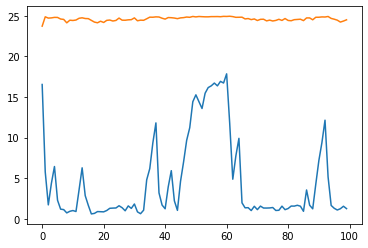

In [3]:
torch.manual_seed(0)

K = 3
D = 2
T = 100

As = [random_rotation(D) for _ in range(K)]
true_tran = LinearTransformation(K=K, d_in=D, d_out=D, As=As)

bounds = np.array([[0, 20], [-5, 25]])
mus_init = np.tile([[10, 15]], (K, 1))


true_observation = ARSigmoidNormalObservation(K=K, D=D, M=0, transformation=true_tran,
                                              mus_init=mus_init, bounds=bounds, alpha=0.2)

true_model = HMM(K=K, D=D, M=0, observation=true_observation)

z, data = true_model.sample(T, return_np=False)

plt.plot(data.numpy());

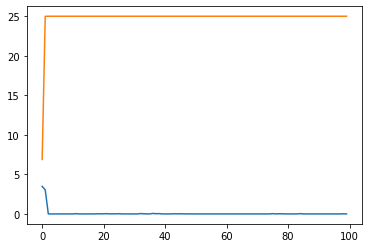

In [4]:
true_observation = ARSigmoidNormalObservation(K=K, D=D, M=0, transformation=true_tran, bounds=bounds, alpha=1.0)

true_model = HMM(K=K, D=D, M=0, observation=true_observation)

z, data = true_model.sample(T, return_np=False)

plt.plot(data.numpy());

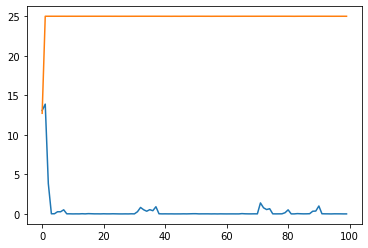

In [5]:
true_observation = ARSigmoidNormalObservation(K=K, D=D, M=0, transformation=true_tran, bounds=bounds, alpha=0.5)

true_model = HMM(K=K, D=D, M=0, observation=true_observation)

z, data = true_model.sample(T, return_np=False)

plt.plot(data.numpy());

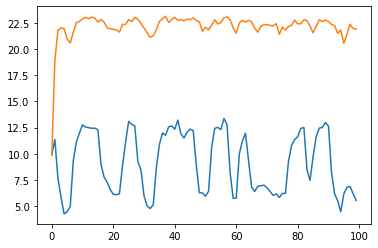

In [6]:
true_observation = ARSigmoidNormalObservation(K=K, D=D, M=0, transformation=true_tran, bounds=bounds, alpha=0.1)

true_model = HMM(K=K, D=D, M=0, observation=true_observation)

z, data = true_model.sample(T, return_np=False)

plt.plot(data.numpy())

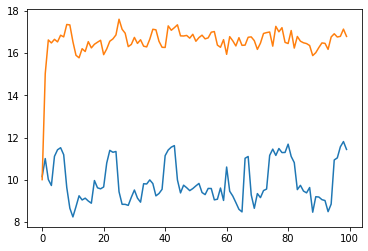

In [7]:
true_observation = ARSigmoidNormalObservation(K=K, D=D, M=0, transformation=true_tran, bounds=bounds, alpha=0.05)

true_model = HMM(K=K, D=D, M=0, observation=true_observation)

z, data = true_model.sample(T, return_np=False)

plt.plot(data.numpy())

# now do model fitting

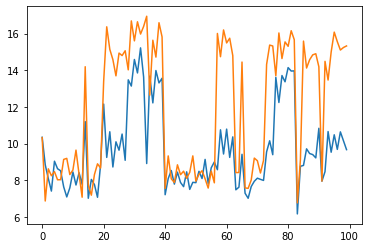

In [8]:
As = npr.randn(K, D, D) * 0.5

true_tran = LinearTransformation(K=K, d_in=D, d_out=D, As=As)
bounds = np.array([[0, 20], [-5, 25]])

true_observation = ARSigmoidNormalObservation(K=K, D=D, M=0, transformation=true_tran, bounds=bounds, alpha=0.1)

true_model = HMM(K=K, D=D, M=0, observation=true_observation)

z, data = true_model.sample(T, return_np=False)

plt.plot(data.numpy());

In [9]:
tran = LinearTransformation(K=K, d_in=D, d_out=D)
observation = ARSigmoidNormalObservation(K=K, D=D, M=0, transformation=tran, bounds=bounds, alpha=0.1)
model = HMM(K=K, D=D, M=0, observation=observation)

In [10]:
model.loss(data)

tensor(6733.1965, dtype=torch.float64, grad_fn=<MulBackward0>)

In [11]:
true_model.loss(data)

tensor(222.6892, dtype=torch.float64, grad_fn=<MulBackward0>)

In [12]:
num_iters = 15000

pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.001)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)    
    loss.backward(retain_graph=True)
    optimizer.step()
    
    loss = loss.detach().numpy()
    losses.append(loss)
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)

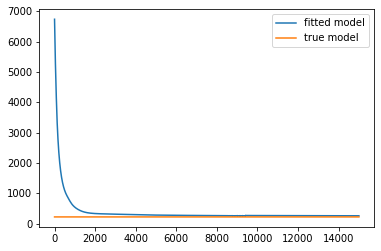

In [13]:
true_loss = true_model.loss(data)
plt.plot(losses, label='fitted model')
plt.plot(np.arange(num_iters), [true_loss]*num_iters, label='true model')
plt.legend()
plt.show()

In [14]:
infer_z = model.most_likely_states(data)

perm = find_permutation(z.numpy(), infer_z, K1=K, K2=K)

model.permute(perm)
hmm_z = model.most_likely_states(data)


In [15]:
x_predict_arr = k_step_prediction(model, hmm_z, data)

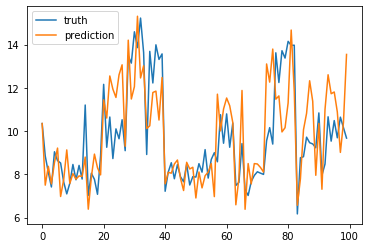

In [16]:
plt.plot(data[:,0].numpy(), label='truth')
plt.plot(x_predict_arr[:,0], label='prediction')
plt.legend();

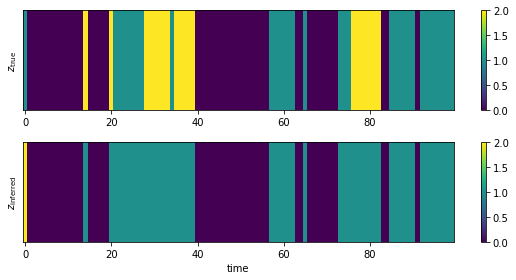

In [17]:
# Plot the true and inferred discrete states
slc = slice(0, T)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(z[None, slc], aspect="auto")
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])
plt.colorbar()

plt.subplot(212)
plt.imshow(hmm_z[None,slc], aspect="auto")
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")
plt.colorbar()

plt.tight_layout()